In [1]:
# Define your custom dataset class
import torch
import os
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
ground_truth_points_csv = pd.read_csv('/kaggle/input/ground-truth-bpd-ocd/role_challenge_dataset_ground_truth.csv')
ground_truth_points_df = pd.DataFrame(ground_truth_points_csv)
ground_truth_points_df

,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363
4,004_HC.png,300,277,611,534,53,452,494,308
...,...,...,...,...,...,...,...,...,...
617,497_HC.png,407,77,432,411,181,270,634,281
618,498_HC.png,445,75,412,458,129,243,687,275
619,499_2HC.png,432,105,411,470,194,284,647,296
620,499_HC.png,356,119,357,484,138,347,608,272


In [3]:
key_list = ['ofd_1_x','ofd_1_y','ofd_2_x','ofd_2_y','bpd_1_x','bpd_1_y','bpd_2_x','bpd_2_y']

In [4]:
image_paths = []
paths = []
directory = '/kaggle/input/bpd-ocd-landmark-detection/images/'

for file_name in os.listdir(directory):
    paths.append(file_name)
    # Accessing the first element to check

In [5]:
for image_path in paths:
    image = Image.open(directory+image_path)
    image_array = np.array(image)
    if image_array.shape == (540,800):
        image_paths.append(image_path)

In [6]:
def scale_landmarks(landmarks, original_size, new_size):
    # Get scaling factors for width and height
    scale_w = new_size[1] / original_size[1]
    scale_h = new_size[0] / original_size[0]

    # Scale landmarks
    scaled_landmarks = []
    for landmark in landmarks:
        # Scale x and y coordinates
        x_scaled = int(landmark[0] * scale_w)
        y_scaled = int(landmark[1] * scale_h)
        scaled_landmarks.append((x_scaled, y_scaled))

    return scaled_landmarks

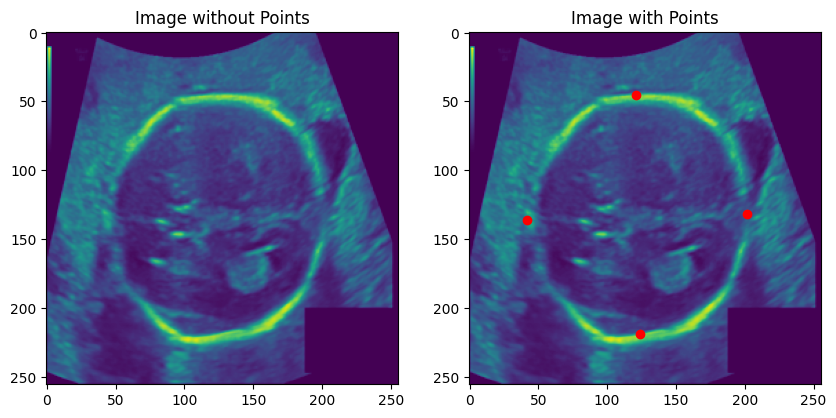

In [7]:
# Load the PNG image
index = 1
image_path = image_paths[index]
df_index = ground_truth_points_df[ground_truth_points_df['image_name']==image_paths[index]].index[0]
image = Image.open(directory+image_path)
image = image.resize((256, 256))


# Convert image to numpy array
# Show the plot
image_array = np.array(image)/255
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image without points
axes[0].imshow(image)
axes[0].set_title('Image without Points')

# Plot the image with points
axes[1].imshow(image)
axes[1].set_title('Image with Points')


# Define landmark points (example)
landmark_points = []
point = []
for n , key in enumerate(key_list):
    if n % 2 == 0:
        point.append(ground_truth_points_df[key][df_index])
    if n % 2 == 1:
        point.append(ground_truth_points_df[key][df_index])
        landmark_points.append(point)
        point = []
landmark_points = scale_landmarks(landmark_points,(540,800),(256,256))
# Plot each landmark point
for point in landmark_points:
#     print(point[0])
    axes[1].plot(point[0], point[1], 'ro')  # 'ro' for red circle marker
plt.show()

In [7]:

def get_land_mark_points(key_list,index):
    landmark_points = []
    point = []
    for n , key in enumerate(key_list):
        if n % 2 == 0:
            point.append(ground_truth_points_df[key][index])
        if n % 2 == 1:
            point.append(ground_truth_points_df[key][index])
            landmark_points.append(point)
            point = []
    return landmark_points
print(get_land_mark_points(key_list,3))

[[424, 105], [407, 462], [305, 349], [547, 363]]


In [ ]:
# generating gaussian heat map
def generate_heatmap(image_size, landmark_coords, sigma=3):
    x_grid, y_grid = np.meshgrid(np.arange(image_size[1]), np.arange(image_size[0]))
    heatmap = np.zeros(image_size)

    for x, y in landmark_coords:
        # Compute Gaussian distribution around each landmark
        dist = np.exp(-((x_grid - x) ** 2 + (y_grid - y) ** 2) / (2 * sigma ** 2))
        heatmap += dist

    return heatmap

# Example usage
heatmap = generate_heatmap((540,800), landmark_points)
heatmap = heatmap.resize((256,256))
plt.imshow(heatmap)

In [8]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths,df,directory,key_list,transform=None):
        self.image_paths = image_paths
        self.landmarks = ground_truth_points_df
        self.transform = transform
        self.directory = directory 
        self.key_list = key_list

    def __len__(self):
        return len(self.image_paths)
    def __generate_heatmap__(self,image_size, landmark_coords, sigma=3):
        x_grid, y_grid = np.meshgrid(np.arange(image_size[1]), np.arange(image_size[0]))
        heatmap = np.zeros(image_size)

        for x, y in landmark_coords:
            # Compute Gaussian distribution around each landmark
            dist = np.exp(-((x_grid - x) ** 2 + (y_grid - y) ** 2) / (2 * sigma ** 2))
            heatmap += dist

        return heatmap
    def __scale_landmarks__(self,landmarks, original_size, new_size):
        # Get scaling factors for width and height
        scale_w = new_size[1] / original_size[1]
        scale_h = new_size[0] / original_size[0]

        # Scale landmarks
        scaled_landmarks = []
        for landmark in landmarks:
            # Scale x and y coordinates
            x_scaled = int(landmark[0] * scale_w)
            y_scaled = int(landmark[1] * scale_h)
            scaled_landmarks.append((x_scaled, y_scaled))

        return scaled_landmarks
    def __get_land_mark_points__(self,index):
        key_list = self.key_list
        landmark_points = []
        point = []
        for n , key in enumerate(key_list):
            if n % 2 == 0:
                point.append(ground_truth_points_df[key][index])
            if n % 2 == 1:
                point.append(ground_truth_points_df[key][index])
                landmark_points.append(point)
                point = []
        return landmark_points
    def __getitem__(self, idx):
        im_path = self.image_paths[idx]
        image = Image.open(directory+im_path)
        image = image.resize((256,256))
        image = np.array(image)/255
        landmark_key = ground_truth_points_df[ground_truth_points_df['image_name']==image_path].index[0]
        landmarks = self.__get_land_mark_points__(landmark_key)
        landmarks = self.__scale_landmarks__(landmarks,(540,800),(256,256))
        heat_map = self.__generate_heatmap__((256,256),landmarks)
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image).unsqueeze(0).float(),torch.tensor(heat_map).unsqueeze(0).float()


# Define transformations for data augmentation or preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor()            # Convert image to tensor
])

# Create an instance of the dataset
dataset = LandmarkDataset(image_paths=image_paths,df=ground_truth_points_df,directory=directory,key_list=key_list)

# Define data loader
batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
class NetworkSCN(nn.Module):
    def __init__(self, num_landmarks):
        super(NetworkSCN, self).__init__()
        self.num_landmarks = num_landmarks
        
        # Define convolutional layers for local appearance
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, padding=2)  # Adjusted input channels to 1
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.conv_local_heatmaps = nn.Conv2d(in_channels=128, out_channels=num_landmarks, kernel_size=5, padding=2)
        
        # Define convolutional layers for spatial configuration
        self.conv_spatial = nn.Conv2d(in_channels=num_landmarks, out_channels=1, kernel_size=15, padding=7)
        
    def forward(self, x):
        # Forward pass for local appearance
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        local_heatmaps = self.conv_local_heatmaps(x)
        
        # Forward pass for spatial configuration
        local_heatmaps_downsampled = F.avg_pool2d(local_heatmaps, kernel_size=8)
        spatial_heatmaps_downsampled_split = []
        for i in range(self.num_landmarks):
            local_heatmaps_except_i = torch.cat([local_heatmaps_downsampled[:, j, :, :] for j in range(self.num_landmarks) if i != j], dim=1)
            spatial_heatmaps_downsampled_split.append(self.conv_spatial(local_heatmaps_except_i))
        spatial_heatmaps_downsampled = torch.cat(spatial_heatmaps_downsampled_split, dim=1)
        spatial_heatmaps = F.interpolate(spatial_heatmaps_downsampled, scale_factor=8, mode='bilinear', align_corners=False)
        
        return local_heatmaps, spatial_heatmaps


In [23]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.conv1 = ResidualBlock(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = ResidualBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Expansive Path
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(128, 64)
        self.conv7 = nn.Conv2d(64, 1, kernel_size=1)  # Output layer
        
    def forward(self, x):
        # Contracting Path
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        
        # Bottleneck
        x4 = self.pool3(x3)
        x4 = self.bottleneck(x4)
        
        # Expansive Path
        x = self.upconv3(x4)
        x = torch.cat([x3, x], dim=1)
        x = self.conv4(x)
        x = self.upconv2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv5(x)
        x = self.upconv1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv6(x)
        
        # Output layer
        x = self.conv7(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Example usage:
# Initialize the UNet model


In [24]:
# Assuming you have your dataset class defined, let's call it LandmarkDataset
# from landmark_dataset import LandmarkDataset

# Define your dataset and DataLoader
# dataset = LandmarkDataset(...)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
# Assuming you have already defined your NetworkSCN class and dataloader

# Initialize the model, loss function, and optimizer
# Assuming you have your dataset class defined, let's call it LandmarkDataset
# from landmark_dataset import LandmarkDataset

# Initialize your dataset
# dataset = LandmarkDataset(...)

# Assuming you have a DataLoader called dataloader that loads batches of data
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = UNet().cuda()  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, landmarks_gt = data  # Assuming your dataset returns inputs and ground truth landmarks
        inputs, landmarks_gt = inputs.cuda(), landmarks_gt.cuda()  # Move inputs and landmarks to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, landmarks_gt)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    if epoch % 5 == 4:  # Save the model every 5 iterations
        torch.save(model.state_dict(), 'model_checkpoint.pth')

print('Finished Training')



[1,   100] loss: 0.009
[1,   200] loss: 0.003
[1,   300] loss: 0.002
[2,   100] loss: 0.002
[2,   200] loss: 0.002
[2,   300] loss: 0.002
[3,   100] loss: 0.002
[3,   200] loss: 0.002
[3,   300] loss: 0.002
[4,   100] loss: 0.002
[4,   200] loss: 0.002
[4,   300] loss: 0.002
[5,   100] loss: 0.002
[5,   200] loss: 0.002
[5,   300] loss: 0.002
[6,   100] loss: 0.002
[6,   200] loss: 0.002
[6,   300] loss: 0.002
[7,   100] loss: 0.002
[7,   200] loss: 0.002
[7,   300] loss: 0.002
[8,   100] loss: 0.002
[8,   200] loss: 0.002
[8,   300] loss: 0.002
[9,   100] loss: 0.002
[9,   200] loss: 0.002
[9,   300] loss: 0.002
[10,   100] loss: 0.002
[10,   200] loss: 0.002
[10,   300] loss: 0.002
[11,   100] loss: 0.002
[11,   200] loss: 0.002
[11,   300] loss: 0.002
[12,   100] loss: 0.001
[12,   200] loss: 0.001
[12,   300] loss: 0.002
[13,   100] loss: 0.001
[13,   200] loss: 0.001
[13,   300] loss: 0.001
[14,   100] loss: 0.001
[14,   200] loss: 0.001
[14,   300] loss: 0.001
[15,   100] loss: 0

In [27]:
model = UNet().cuda()

# Load the saved model state dictionary
model_path = 'path_to_your_saved_model.pth'  # Replace 'path_to_your_saved_model.pth' with the path to your saved model file
model.load_state_dict(torch.load('/kaggle/working/model_checkpoint.pth'))

# Set the model to evaluation mode
model.eval()

UNet(
  (conv1): ResidualBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

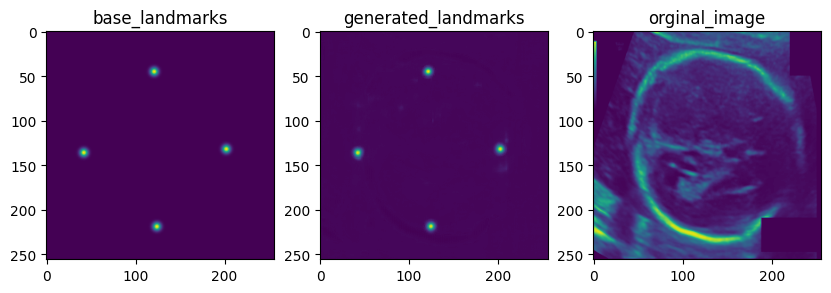

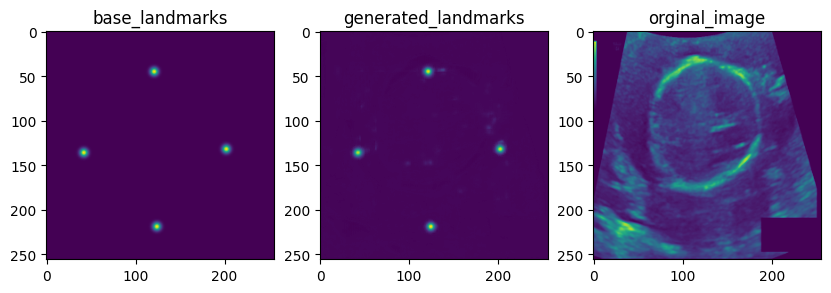

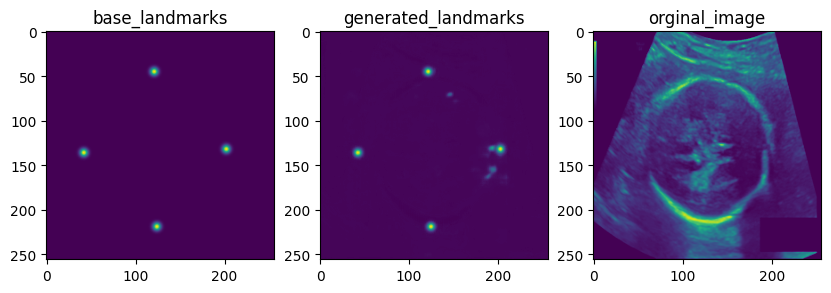

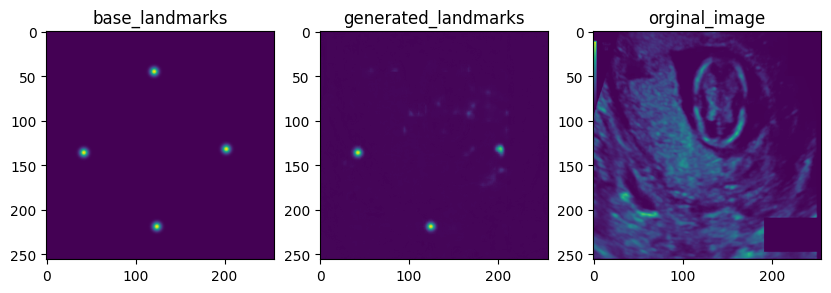

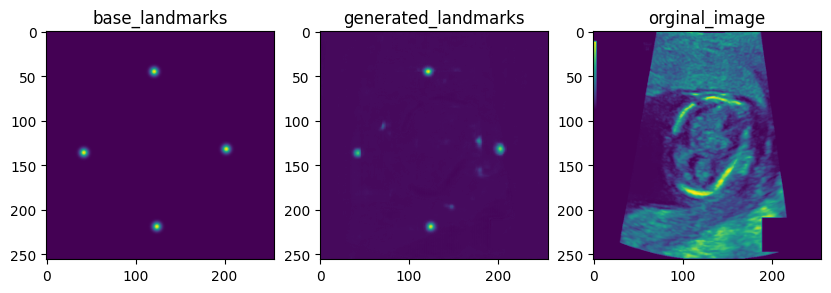

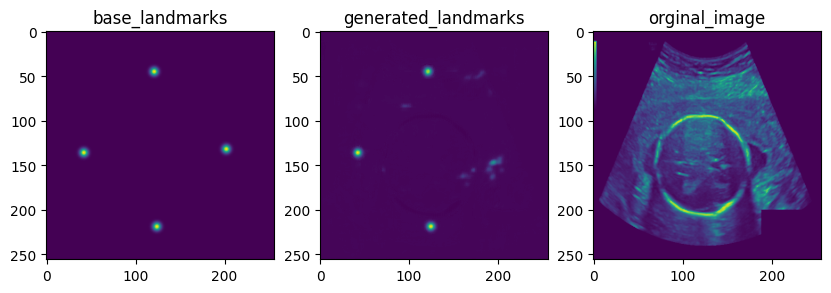

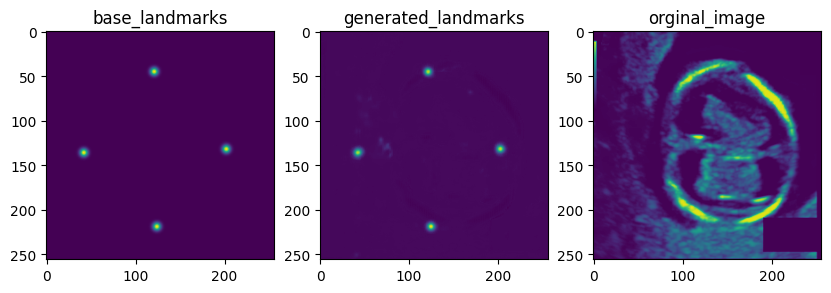

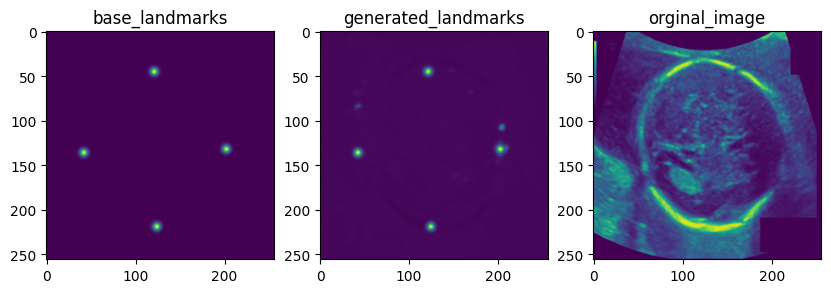

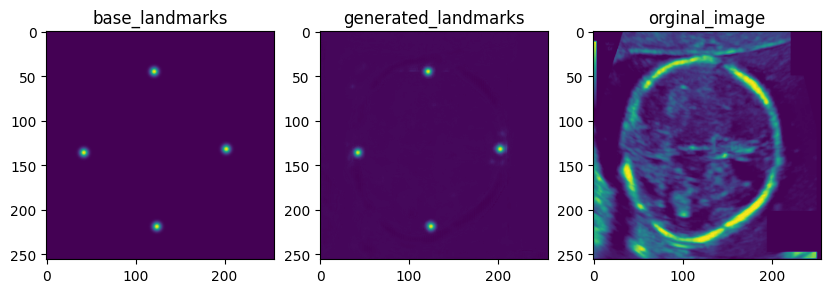

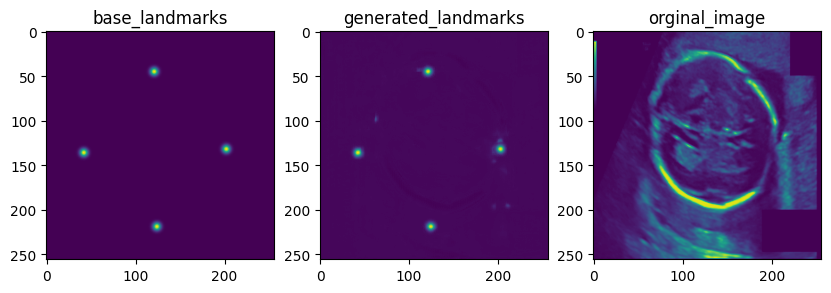

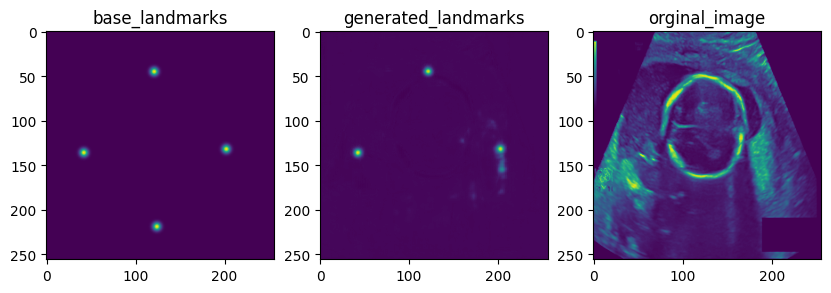

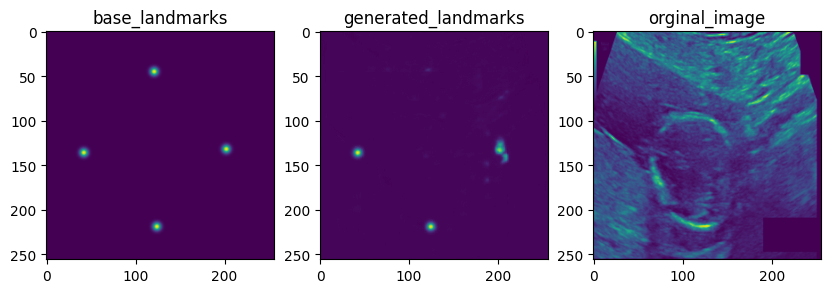

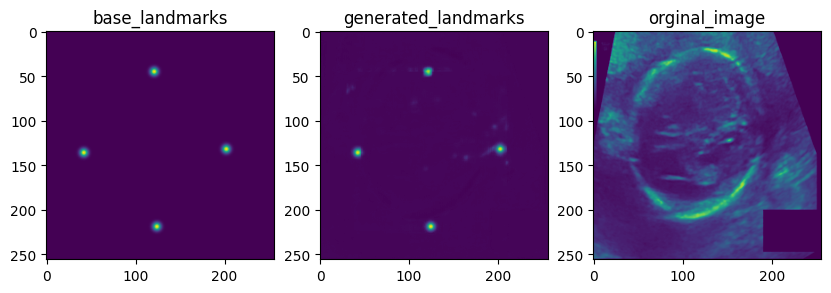

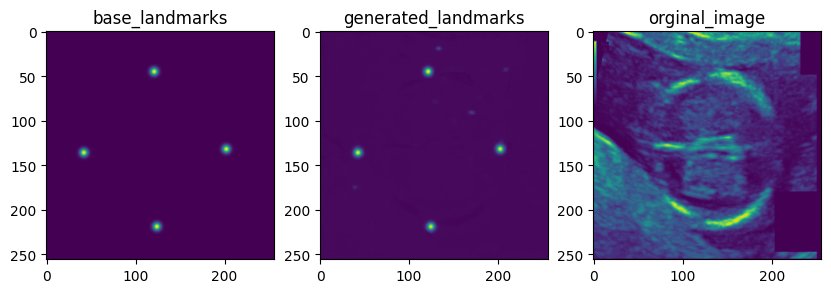

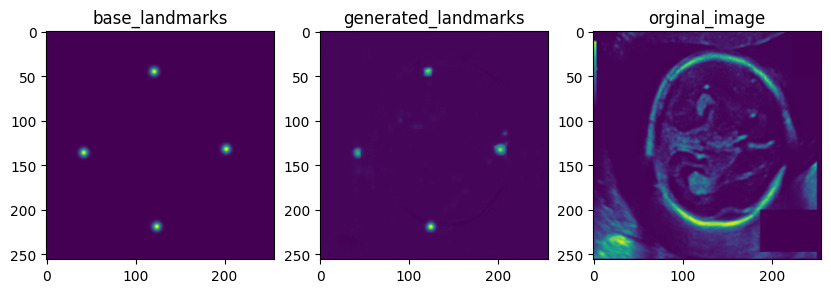

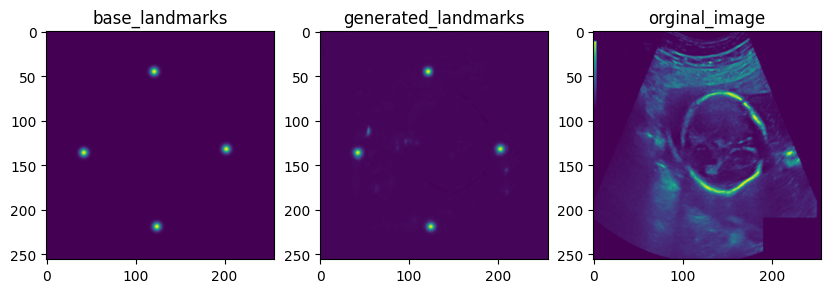

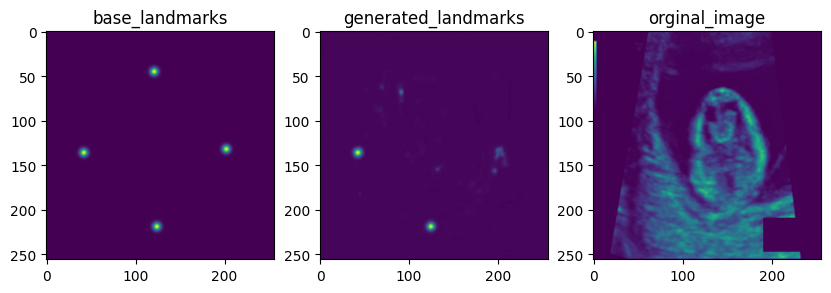

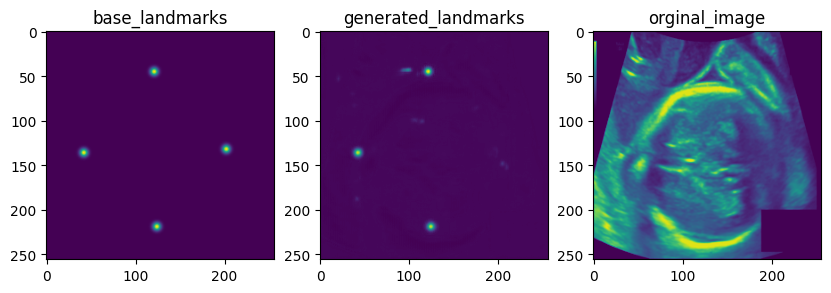

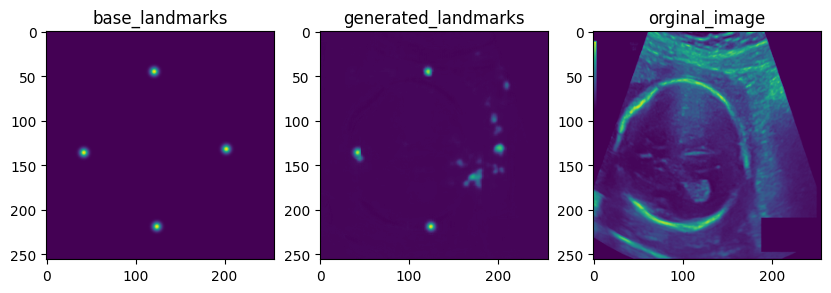

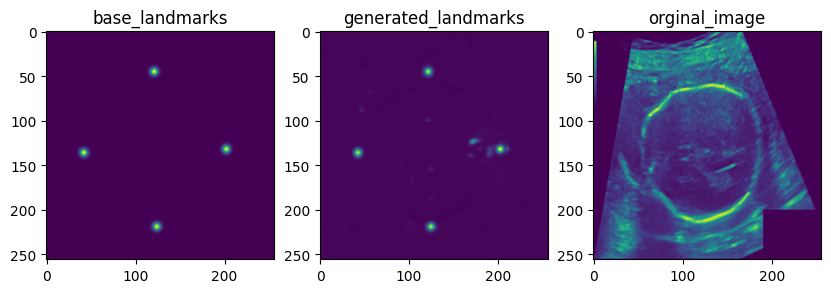

In [46]:
cnt = 0
for data in dataloader:
    if cnt == 20:
        break
    cnt+=1
    inp , landmark = data
    out = model(inp.cuda())
    generated_landmarks = out[1].squeeze(0).cpu().detach().numpy()
    base_landmarks = landmark[0].squeeze(0)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(base_landmarks)
    axes[0].set_title('base_landmarks')
    axes[1].imshow(generated_landmarks)
    axes[1].set_title('generated_landmarks')
    axes[2].imshow(inp[1].squeeze(0))
    axes[2].set_title('orginal_image')